
#install and import required packages

In [ ]:
!pip install -q seqeval
!pip install -q livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import re
import tensorflow

from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.layers import LSTM, Embedding, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model, Input
from livelossplot import PlotLossesKeras
from future.utils import iteritems

import warnings
warnings.filterwarnings("ignore")

#import data directly from kaggle

In [ ]:
#@title Kaggle Credential { display-mode: "form" }

username = '' #@param {type: "string"}
api_key = '' #@param {type: "string"}


if username and api_key:
    token = {"username": username, "key": api_key}

    !mkdir ~/.kaggle
    !mkdir /content/.kaggle
    with open('/content/.kaggle/kaggle.json', 'w') as f:
        json.dump(token, f)

    !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json

# Replace with your dataset's API command
!kaggle datasets download -d shayanbemanian/arman-persian-ner-dataset

!unzip arman-persian-ner-dataset.zip

 50% 1.00M/2.02M [00:00<00:00, 1.79MB/s]
100% 2.02M/2.02M [00:00<00:00, 3.09MB/s]
Archive:  arman-persian-ner-dataset.zip
  inflating: dev.txt                 
  inflating: test.txt                
  inflating: train.txt               


#data exploration and cleaning

In [ ]:
columns = ['word', 'IOB_tag']

#The dataset consists of three fold
data_part1 = pd.read_csv('train.txt',names=columns, delimiter=' ')
data_part2 = pd.read_csv('dev.txt',names=columns, delimiter=' ')
data_part3 = pd.read_csv('test.txt',names=columns, delimiter=' ')

#data concatenation
data = pd.concat([data_part1, data_part2, data_part3])
print('shape of dataframe is: ', data.shape, '\n', '-----------------------------------')
data.sample(5)

shape of dataframe is:  (731635, 2) 
 -----------------------------------


,word,IOB_tag
26113,و,O
29842,را,O
123187,خشک,O
151459,در,O
50465,ـ,O


In [ ]:
def create_sequences(data, sentence_delimiters=['.', '?', '!']):

    # Group the data by sentence delimiter using the regular expression pattern
    grouped = data.groupby((data['word'].isin(sentence_delimiters)).cumsum())

    # Extract the words and tags for each group using a list comprehension
    sequences = [(group['word'].tolist(), group['IOB_tag'].tolist()) for _, group in grouped]

    # Return the list of sequences
    return sequences


In [ ]:
sequences = create_sequences(data)
print(sequences[4])

(['.', 'حمید', 'طاهایی', 'افزود', ':', 'برای', 'اجرای', 'این', 'طرحها', '0', 'میلیارد', 'و', '0', 'میلیون', 'ریال', 'اعتبار', 'هزینه', 'شده', 'است'], ['O', 'B-pers', 'I-pers', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


In [ ]:
#convert list of sequences to pandas dataframe
data_new = pd.DataFrame(sequences, columns=columns)

data_new.insert(loc=0, column='sentence_number', value=range(1, 1 + len(data_new)))

data_new.head(3)

,sentence_number,word,IOB_tag
0,1,"[به, عنوان, مثال, وقتی, نشریات, مدافع, اصول, و...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,2,"[., دکتر, اصغری, دبیر, چهارمین, همایش, انجمن, ...","[O, O, B-pers, O, B-event, I-event, I-event, I..."
2,3,"[., دکتر, اکبر, میرعرب, در, همایش, بررسی, و, پ...","[O, O, B-pers, I-pers, O, B-event, I-event, I-..."


In [ ]:
#Expand each row
words_col = data_new.explode('word')[['sentence_number','word']].reset_index(drop=True)

tags_col = data.explode('IOB_tag')[['IOB_tag']].reset_index(drop=True)

df = pd.concat([words_col, tags_col], axis=1)
df.head(3)

,sentence_number,word,IOB_tag
0,1,به,O
1,1,عنوان,O
2,1,مثال,O


In [ ]:
#convert list of sentences to word_tag_pairs tuple
def get_word_tag_pairs(data):
    grouped = data.groupby('sentence_number')
    sentences = []
    for _, sentence in grouped:
        word_tag_pairs = list(zip(sentence['word'], sentence['IOB_tag']))
        sentences.append(word_tag_pairs)
    return sentences

In [ ]:
sentences = get_word_tag_pairs(df)

print('number of sentences is: ', len(sentences), '\n', '...............................')
print('sample of sentence with pairs of word and_IOB tag: ','\n','\n', sentences[4])

number of sentences is:  22663 
 ...............................
sample of sentence with pairs of word and_IOB tag:  
 
 [('.', 'O'), ('حمید', 'B-pers'), ('طاهایی', 'I-pers'), ('افزود', 'O'), (':', 'O'), ('برای', 'O'), ('اجرای', 'O'), ('این', 'O'), ('طرحها', 'O'), ('0', 'O'), ('میلیارد', 'O'), ('و', 'O'), ('0', 'O'), ('میلیون', 'O'), ('ریال', 'O'), ('اعتبار', 'O'), ('هزینه', 'O'), ('شده', 'O'), ('است', 'O')]


In [ ]:
df.isnull().sum()

sentence_number    0
word               0
IOB_tag            0
dtype: int64

In [ ]:
df['IOB_tag'].value_counts()

O          659513
I-org       15886
B-org       13114
B-loc        9899
B-pers       9449
I-event      5574
I-pers       5515
I-fac        2730
I-loc        2567
I-pro        2060
B-pro        2054
B-event      1667
B-fac        1607
Name: IOB_tag, dtype: int64

In [ ]:
tags=list(set(df['IOB_tag']))

nu_tags=len(tags)
print('number of unique tags: ', nu_tags)

number of unique tags:  13


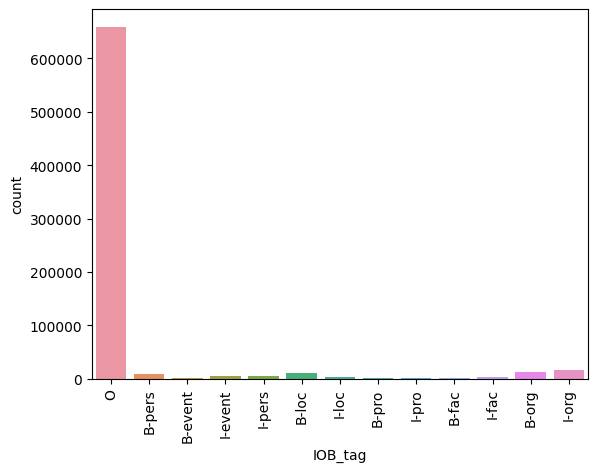

In [ ]:
ax = sns.countplot(x='IOB_tag', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

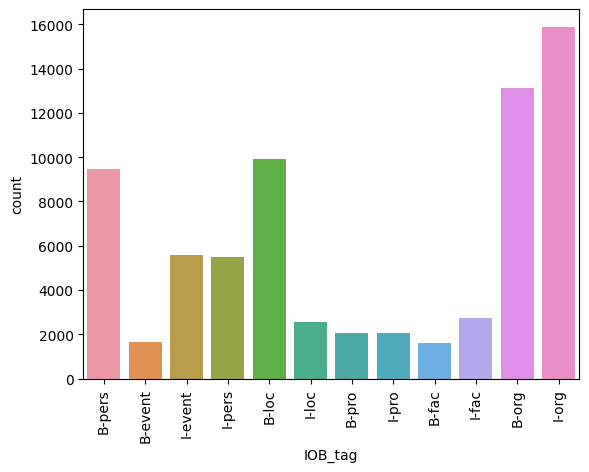

In [ ]:
#drop 'O' tag in visualization
ax = sns.countplot(x='IOB_tag', data=df.loc[df['IOB_tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
words=list(set(df['word']))

nu_words=len(words)
print('number of unique words: ', nu_words)

number of unique words:  18079


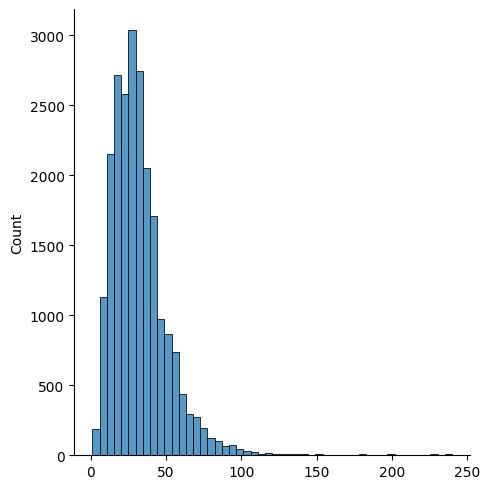

In [ ]:
#Word length distribution
sns.displot([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
max_len = max([len(s) for s in sentences])
min_len = min([len(s) for s in sentences])

print ('Max_len:', max_len, '    ***    ', 'min_len:', min_len)

Max_len: 240     ***     min_len: 1


In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: j for j, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

print(tag2idx)

{'B-event': 0, 'B-fac': 1, 'I-event': 2, 'I-pers': 3, 'B-pro': 4, 'I-pro': 5, 'I-fac': 6, 'I-loc': 7, 'O': 8, 'B-loc': 9, 'B-org': 10, 'B-pers': 11, 'I-org': 12}


In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=0.0)

y = [[tag2idx[t[1]] for t in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])

In [ ]:
X[1]

array([11958,  4694,  9324, 17799, 16489, 14162, 16290,  2683, 17017,
        3543, 17257, 13833, 10569, 16491,  5736, 11414,   101,  9195,
       10280,  4818,  3248,   109, 14162, 12567, 16543,  9195, 16333,
       14685, 10280, 16696,  5252, 10477, 12526,  3543, 12012, 13792,
       14162, 14087,  1281,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
y[1]

array([ 8,  8, 11,  8,  0,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [ ]:
Y = to_categorical(y)

In [ ]:
print('shape of labals before one_hot_encoding:', y.shape, '\n',
      'shape of labals after one_hot_encoding:',Y.shape)

shape of labals before one_hot_encoding: (22663, 240) 
 shape of labals after one_hot_encoding: (22663, 240, 13)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [ ]:
print('shape of X_train:', X_train.shape,'\n', 'shape of y_train:', y_train.shape)

shape of X_train: (19263, 240) 
 shape of y_train: (19263, 240, 13)


#create and train LSTM model

In [ ]:
#Functional API model
input_word = Input(shape=(max_len,))
emd_layer = Embedding(input_dim=nu_words, output_dim=max_len, input_length=max_len)(input_word)
dropout_layer = SpatialDropout1D(0.1)(emd_layer)
BLSTM_layer = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(dropout_layer)
output = TimeDistributed(Dense(nu_tags, activation='softmax'))(BLSTM_layer)

model = Model(input_word, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240)]             0         
                                                                 
 embedding (Embedding)       (None, 240, 240)          4338960   
                                                                 
 spatial_dropout1d (Spatial  (None, 240, 240)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 240, 200)          272800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 240, 13)           2613      
 ributed)                                                        
                                                             

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

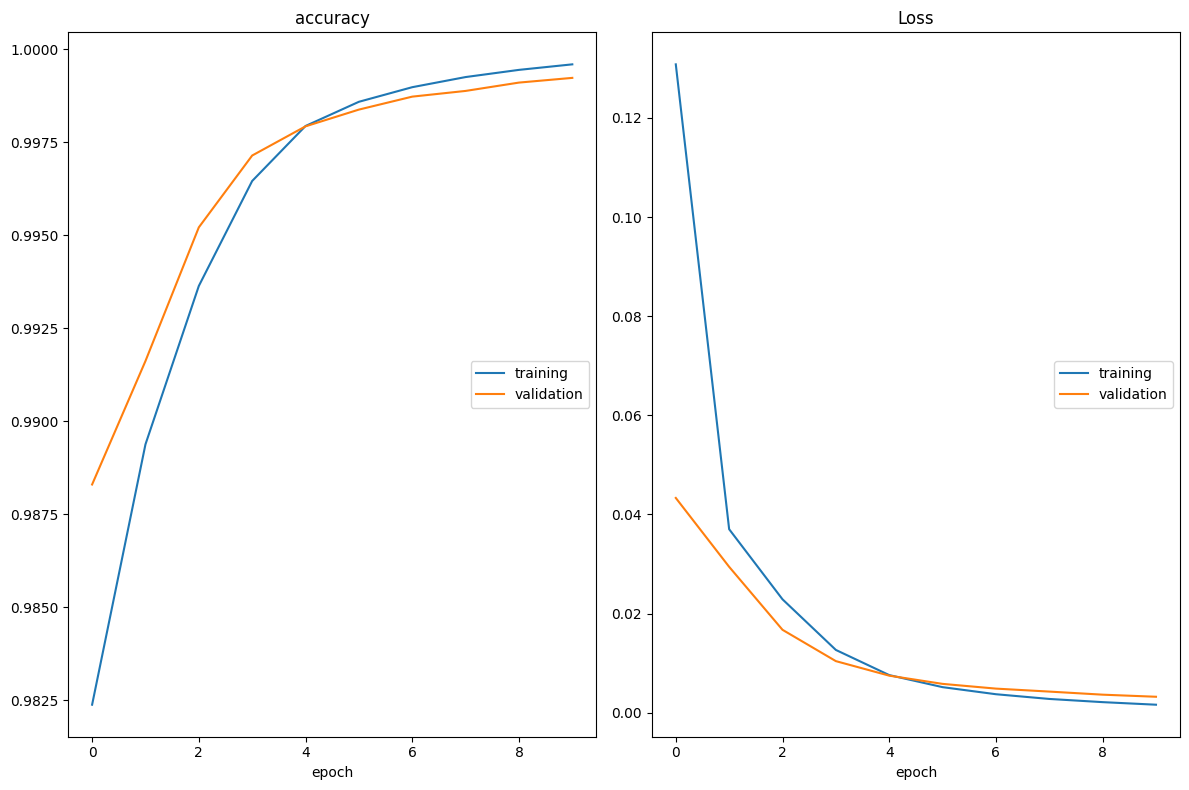

accuracy
	training         	 (min:    0.982, max:    1.000, cur:    1.000)
	validation       	 (min:    0.988, max:    0.999, cur:    0.999)
Loss
	training         	 (min:    0.002, max:    0.131, cur:    0.002)
	validation       	 (min:    0.003, max:    0.043, cur:    0.003)
241/241 [==============================] - 460s 2s/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0032 - val_accuracy: 0.9992


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
#evaluate model
model.evaluate(X_test, np.array(y_test))

107/107 [==============================] - 15s 139ms/step - loss: 0.0032 - accuracy: 0.9992


[0.003209381364285946, 0.9992340803146362]

In [ ]:
def print_word_predictions(X_test, y_test, words, tags, model):
    # Randomly select an index
    i = np.random.randint(0, X_test.shape[0])

    # Predict using the model
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)

    # Get true label
    y_true = np.argmax(np.array(y_test), axis=-1)[i]

    # Print header
    print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
    print("-" * 30)

    count = 0
    sentence = ''

    # Iterate over each word, true label, and predicted label
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        count += 1

        if count > 20:
            break

        # Build the sentence
        sentence += words[w - 1] + " "

        # Print word, true label, and predicted label
        print("{:15}{:5}\t{}".format(words[w - 1], tags[true], tags[pred]))

    return sentence

sentence = print_word_predictions(X_test, y_test, words, tags, model)

1/1 [==============================] - 1s 735ms/step
Word           True 	Pred

------------------------------
دمای           O    	O
روشنگر         O    	O
قدرتی          O    	O
معجزه‌گر       O    	O
تزئینات        O    	O
کجای           O    	O
ظاهری          O    	O
نکشاند         O    	O
خزعلی          O    	O
زاهدان         B-org	B-org
واصل           I-org	I-org
ردیه‌نویسی     O    	O
جغرافیای       O    	O
نهر            O    	O
گویم           O    	O
مائه           O    	O
آمیزش          O    	O
جزم            O    	O
زمینه‌ای       O    	O
اسرای          O    	O


In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

107/107 [==============================] - 15s 143ms/step


In [ ]:
print(f"F1-score: {f1_score(test_labels, pred_labels)}")
print(f"recall_score: {recall_score(test_labels, pred_labels)}")
print(f"precision_score: {precision_score(test_labels, pred_labels)}")
print(f"accuracy_score: {accuracy_score(test_labels, pred_labels)}")

F1-score: 0.9321130264794739
recall_score: 0.9362727597286683
precision_score: 0.9279900920028309
accuracy_score: 0.999234068627451
